# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

In [1]:
print("hello world!")

hello world!


## Imports entire notebook

In [2]:
# Helper function to check if the code is running in Google Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Usage
if is_colab():
    print("Running in Google Colab")
else:
    print("Not running in Google Colab")


# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast  # Add these imports for mixed precision training
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tqdm.notebook import tqdm
import os
import shutil
import subprocess
import zipfile
import re
import random

Running in Google Colab


## Global Definitions

In [3]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

In [4]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.6.0+cu124
12.4
90300
True


In [5]:
# If we are in colab and we need to mount the drive
if is_colab():
  from google.colab import drive
  # Mount Google Drive
  drive.mount('/content/drive')
  print("Google Drive mounted successfully.")
  data_path = f"/content/drive/MyDrive/{data_path}"
else:
  print("Not in Google Colab.")

Mounted at /content/drive
Google Drive mounted successfully.


# Load Data

In [6]:
train_dataset = loadmat(data_path)
Xtrain = train_dataset['Xtrain']
# Check the shape of the data
print("Shape of Xtrain:", Xtrain.shape)

# Display the first few rows of the data
print("First 10 rows of Xtrain:")
print(Xtrain[:10])

# Convert to a PyTorch tensor if needed
Xtrain_tensor = torch.tensor(Xtrain, dtype=torch.float32, device=device)
print("Xtrain as a PyTorch tensor:", Xtrain_tensor.shape)

Shape of Xtrain: (1000, 1)
First 10 rows of Xtrain:
[[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]
 [ 21]
 [ 32]
 [ 72]
 [138]
 [111]]
Xtrain as a PyTorch tensor: torch.Size([1000, 1])


# Generate plot of data

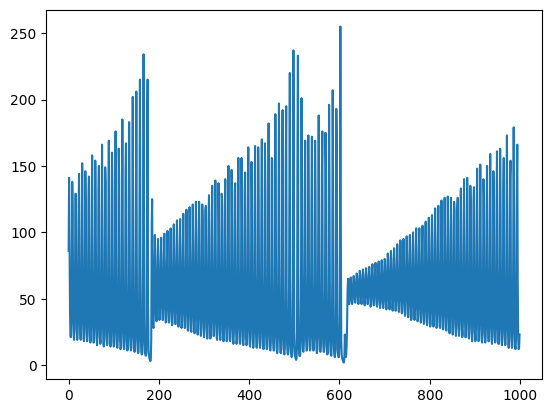

In [7]:
plt.plot(Xtrain)

# Divide data into training and test

In [21]:
training = Xtrain[:800]
testing = Xtrain[800:]
print("Training shape: ", training.shape, ". Testing shape", testing.shape)
print("Actual shape try", Xtrain_tensor[0:800])

Training shape:  (800, 1) . Testing shape (200, 1)
Actual shape try tensor([[ 86.],
        [141.],
        [ 95.],
        [ 41.],
        [ 22.],
        [ 21.],
        [ 32.],
        [ 72.],
        [138.],
        [111.],
        [ 48.],
        [ 23.],
        [ 19.],
        [ 27.],
        [ 59.],
        [129.],
        [129.],
        [ 58.],
        [ 27.],
        [ 19.],
        [ 24.],
        [ 46.],
        [112.],
        [144.],
        [ 73.],
        [ 30.],
        [ 20.],
        [ 19.],
        [ 37.],
        [ 92.],
        [152.],
        [ 93.],
        [ 36.],
        [ 20.],
        [ 18.],
        [ 29.],
        [ 71.],
        [146.],
        [117.],
        [ 46.],
        [ 23.],
        [ 18.],
        [ 22.],
        [ 52.],
        [128.],
        [142.],
        [ 62.],
        [ 26.],
        [ 17.],
        [ 19.],
        [ 37.],
        [100.],
        [158.],
        [ 86.],
        [ 32.],
        [ 17.],
        [ 17.],
        [ 27.],
    

# Model & Hyperparameters

In [18]:
input_size = 1
hidden_size = 128
sequence_length = 800
num_layers = 1

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):#, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size, hidden_size, num_layers)

        # input: tensor of shape (sequence size, )

        # End with one fully connected layer from hidden to 1 number
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        # out: tensor of shape (sequence_length, hidden_size)
        # out (800, 128)

        # in the tutorial, the guy takes only the final number, like this:
        # out = out[-1,:]

        # run this through the final layer to get scalar?
        out = self.fc(out)
        return out


# Might need to set nonlinearity from tanh to relu
model = RNN(input_size, hidden_size, num_layers).to(device)
#model = torch.nn.RNN(input_size, hidden_size, num_layers).to(device)

# Loss function (maybe add optimizer?)

In [15]:
criterion = nn.MSELoss() # In the tutorial, crossentropyloss is used instead

# Train the model

In [27]:
num_epochs = 100

for epoch in range(num_epochs):

  # Forward pass
  outputs = model(Xtrain_tensor[0:10])

  loss = criterion(outputs, Xtrain_tensor[0:10])

  # Backpropagate
  loss.backward()

  # Print loss
  print("Epoch: ", epoch, ", loss:", loss.item())



Epoch:  0 , loss: 7569.5234375
Epoch:  1 , loss: 7569.5234375
Epoch:  2 , loss: 7569.5234375
Epoch:  3 , loss: 7569.5234375
Epoch:  4 , loss: 7569.5234375
Epoch:  5 , loss: 7569.5234375
Epoch:  6 , loss: 7569.5234375
Epoch:  7 , loss: 7569.5234375
Epoch:  8 , loss: 7569.5234375
Epoch:  9 , loss: 7569.5234375
Epoch:  10 , loss: 7569.5234375
Epoch:  11 , loss: 7569.5234375
Epoch:  12 , loss: 7569.5234375
Epoch:  13 , loss: 7569.5234375
Epoch:  14 , loss: 7569.5234375
Epoch:  15 , loss: 7569.5234375
Epoch:  16 , loss: 7569.5234375
Epoch:  17 , loss: 7569.5234375
Epoch:  18 , loss: 7569.5234375
Epoch:  19 , loss: 7569.5234375
Epoch:  20 , loss: 7569.5234375
Epoch:  21 , loss: 7569.5234375
Epoch:  22 , loss: 7569.5234375
Epoch:  23 , loss: 7569.5234375
Epoch:  24 , loss: 7569.5234375
Epoch:  25 , loss: 7569.5234375
Epoch:  26 , loss: 7569.5234375
Epoch:  27 , loss: 7569.5234375
Epoch:  28 , loss: 7569.5234375
Epoch:  29 , loss: 7569.5234375
Epoch:  30 , loss: 7569.5234375
Epoch:  31 , loss: